In [81]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [82]:
dataset = MNIST(root='/',download=True,transform=ToTensor())

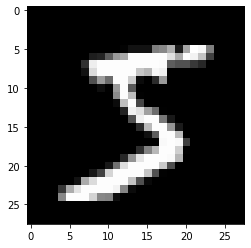

In [83]:
image,label = dataset[0]
plt.imshow(image[0,:,:],cmap='gray')

In [84]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds)

50000

In [85]:
batch_size = 128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers

In [86]:
for images,labels in train_dl:
    inputs = images.reshape(-1,28*28)
    break

In [87]:
input_dim = inputs.shape[-1]
hidden_dim = 32
layer1 = nn.Linear(input_dim,hidden_dim)

In [88]:
layer1_output = layer1(inputs)
layer1_output.shape

torch.Size([128, 32])

In [89]:
relu_output = F.relu(layer1_output)

In [90]:
output_dim = 10
layer2 = nn.Linear(hidden_dim,output_dim)

In [91]:
layer2_output = layer2(relu_output)
layer2_output.shape

torch.Size([128, 10])

In [92]:
inputs.shape

torch.Size([128, 784])

In [93]:
F.cross_entropy(layer2_output,labels)

tensor(2.3057, grad_fn=<NllLossBackward0>)

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

    Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

    The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size. The parameter hidden_size can be configured manually (e.g., 32 or 64).

    We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.

    The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.


In [94]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [95]:
class Mnist(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)

    def forward(self,x):
        x = x.reshape(-1,28*28)
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss, 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [96]:
input_size = 784
hidden_size = 64
num_classes = 10

In [97]:
model = Mnist(input_size, hidden_size=32, out_size=num_classes)

Using a GPU

In [98]:
torch.cuda.is_available()

True

In [99]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [100]:
device = get_default_device()
device

device(type='cuda')

In [101]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [102]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [103]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [104]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [105]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [106]:
# Model (on GPU)
model = Mnist(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

Mnist(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [107]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3246653079986572, 'val_acc': 0.07841797173023224}]

In [108]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2097, val_acc: 0.9346
Epoch [1], val_loss: 0.1476, val_acc: 0.9573
Epoch [2], val_loss: 0.1232, val_acc: 0.9635
Epoch [3], val_loss: 0.1135, val_acc: 0.9664
Epoch [4], val_loss: 0.1030, val_acc: 0.9666


In [110]:
test_dataset = MNIST(root='/', 
                     train=False,
                     transform=ToTensor())

In [111]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


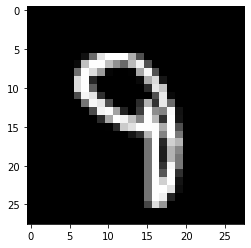

In [112]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))